In [6]:
# ==============================
# 🧠 Brain Tumor Classification — Part 1
# Mount Google Drive + Setup
# ==============================

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# ✅ Set dataset paths
# Example (adjust your paths if needed):
train_dir = '/content/drive/MyDrive/BTC/Training'
val_dir   = '/content/drive/MyDrive/BTC/Validating'  # optional
test_dir  = '/content/drive/MyDrive/BTC/Testing'     # optional

# ✅ Verify GPU
print("TensorFlow version:", tf.__version__)
device_name = tf.test.gpu_device_name()
print("GPU found:", device_name if device_name else "No GPU found!")

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


Mounted at /content/drive
TensorFlow version: 2.19.0
GPU found: /device:GPU:0


In [7]:
# ==============================
# 🧩 Part 2 — Data Preprocessing (Separate Folders)
# ==============================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Data generators for train/validation/test folders
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# ✅ Flow from separate folders (no subset)
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("✅ Dataset Summary:")
print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)
print("Test samples:", test_gen.samples)
print("Class indices:", train_gen.class_indices)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
✅ Dataset Summary:
Train samples: 5712
Validation samples: 1311
Test samples: 394
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [8]:
# ==============================
# 🧠 Part 3 — Model Definition
# ==============================

from keras.applications import DenseNet121
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

# Load DenseNet121 base
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers (optional)
for layer in base_model.layers:
    layer.trainable = True  # or False to freeze

# Custom head
x = Flatten()(base_model.output)
x = Dropout(0.7)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,661,892 (52.12 MB)

 Trainable params: 13,477,636 (51.41 MB)

 Non-trainable params: 184,256 (719.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 2804s 15s/step - accuracy: 0.6083 - loss: 1.0233 - precision: 0.6537 - recall: 0.5445 - val_accuracy: 0.7872 - val_loss: 0.5974 - val_precision: 0.8293 - val_recall: 0.7376 - learning_rate: 1.0000e-04
Epoch 2/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 106s 588ms/step - accuracy: 0.8781 - loss: 0.3635 - precision: 0.8941 - recall: 0.8605 - val_accuracy: 0.8490 - val_loss: 0.3703 - val_precision: 0.8591 - val_recall: 0.8322 - learning_rate: 1.0000e-04
Epoch 3/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 105s 587ms/step - accuracy: 0.9286 - loss: 0.2103 - precision: 0.9356 - recall: 0.9198 - val_accuracy: 0.8383 - val_loss: 0.4621 - val_precision: 0.8460 - val_recall: 0.8337 - learning_rate: 1.0000e-04
Epoch 4/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 105s 586ms/step - accuracy: 0.9424 - loss: 0.1679 - precision: 0.9488 - recall: 0.9344 - val_accuracy: 0.9611 - val_loss: 0.1110 - val_precision: 0.9625 - val_recall: 0.9603 - learning_rate: 1.0000e-04
Epoch 5/60
179/179 ━━━━━━━━━━━━━━

✅ Model saved to: /content/drive/MyDrive/brain_tumor_results/final_tumor_model.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 97s 541ms/step - accuracy: 0.9982 - loss: 0.0053 - precision: 0.9990 - recall: 0.9982
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9918 - loss: 0.0263 - precision: 0.9918 - recall: 0.9918
Train: [0.004284019581973553, 0.998774528503418, 0.9991243481636047, 0.998774528503418]
Validation: [0.017837364226579666, 0.9954233169555664, 0.9954233169555664, 0.9954233169555664]
13/13 ━━━━━━━━━━━━━━━━━━━━ 127s 11s/step - accuracy: 0.6231 - loss: 2.2579 - precision: 0.6196 - recall: 0.6108
Test: [1.184848666191101, 0.799492359161377, 0.8005114793777466, 0.7944162487983704]


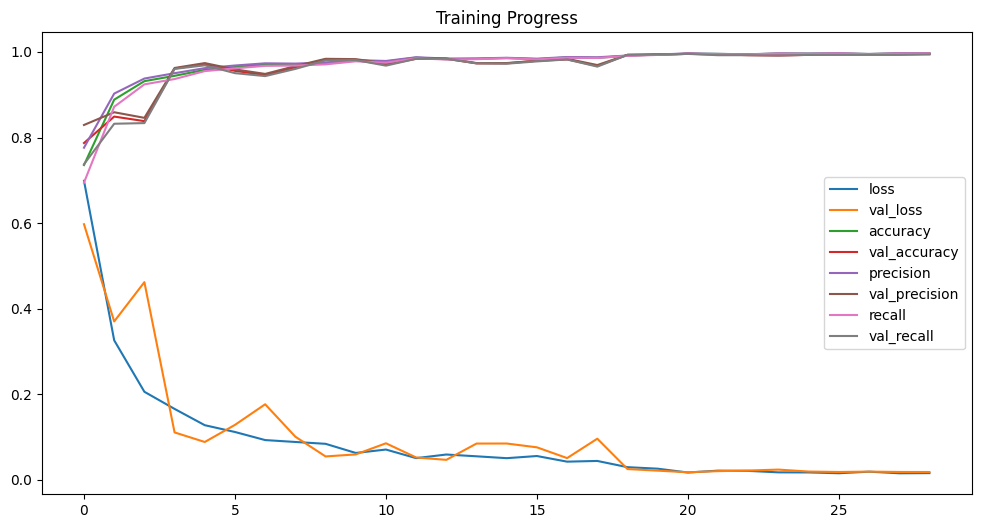

In [9]:
# ==============================
# 🚀 Part 4 — Train & Evaluate
# ==============================

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, monitor='val_loss', factor=0.1, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    epochs=60,
    validation_data=val_gen,
    callbacks=callbacks
)

# Save model
save_path = '/content/drive/MyDrive/brain_tumor_results/final_tumor_model.h5'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)
print("✅ Model saved to:", save_path)

# Evaluate
train_eval = model.evaluate(train_gen)
val_eval = model.evaluate(val_gen)
print("Train:", train_eval)
print("Validation:", val_eval)
test_eval = model.evaluate(test_gen)
print("Test:", test_eval)

# Plot metrics
plt.figure(figsize=(12, 6))
for metric in ['loss', 'accuracy', 'precision', 'recall']:
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
plt.legend()
plt.title("Training Progress")
plt.show()


🔍 Showing Grad-CAM for class: pituitary


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


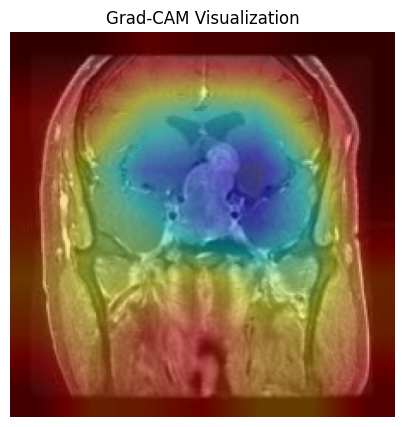

In [11]:
# ==============================
# 🔥 Part 5 — Grad-CAM (Fixed for TF 2.17+)
# ==============================

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model(save_path, compile=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

def preprocess_image(img_path):
    """Read and preprocess image for the model."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return np.expand_dims(img, axis=0)

def grad_cam(img_array, layer_name):
    """Generate Grad-CAM heatmap for a given image array and conv layer."""
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

def display_gradcam(img_path, layer_name='conv5_block16_concat'):
    """Overlay Grad-CAM heatmap on the original image."""
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgb_img = cv2.resize(rgb_img, (224, 224))
    img_array = preprocess_image(img_path)

    heatmap = grad_cam(img_array, layer_name)
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(rgb_img, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()

# 🔍 Example: automatically select a test image
sample_class = os.listdir(test_dir)[0]
sample_image = os.path.join(test_dir, sample_class, os.listdir(os.path.join(test_dir, sample_class))[0])
print(f"🔍 Showing Grad-CAM for class: {sample_class}")
display_gradcam(sample_image)


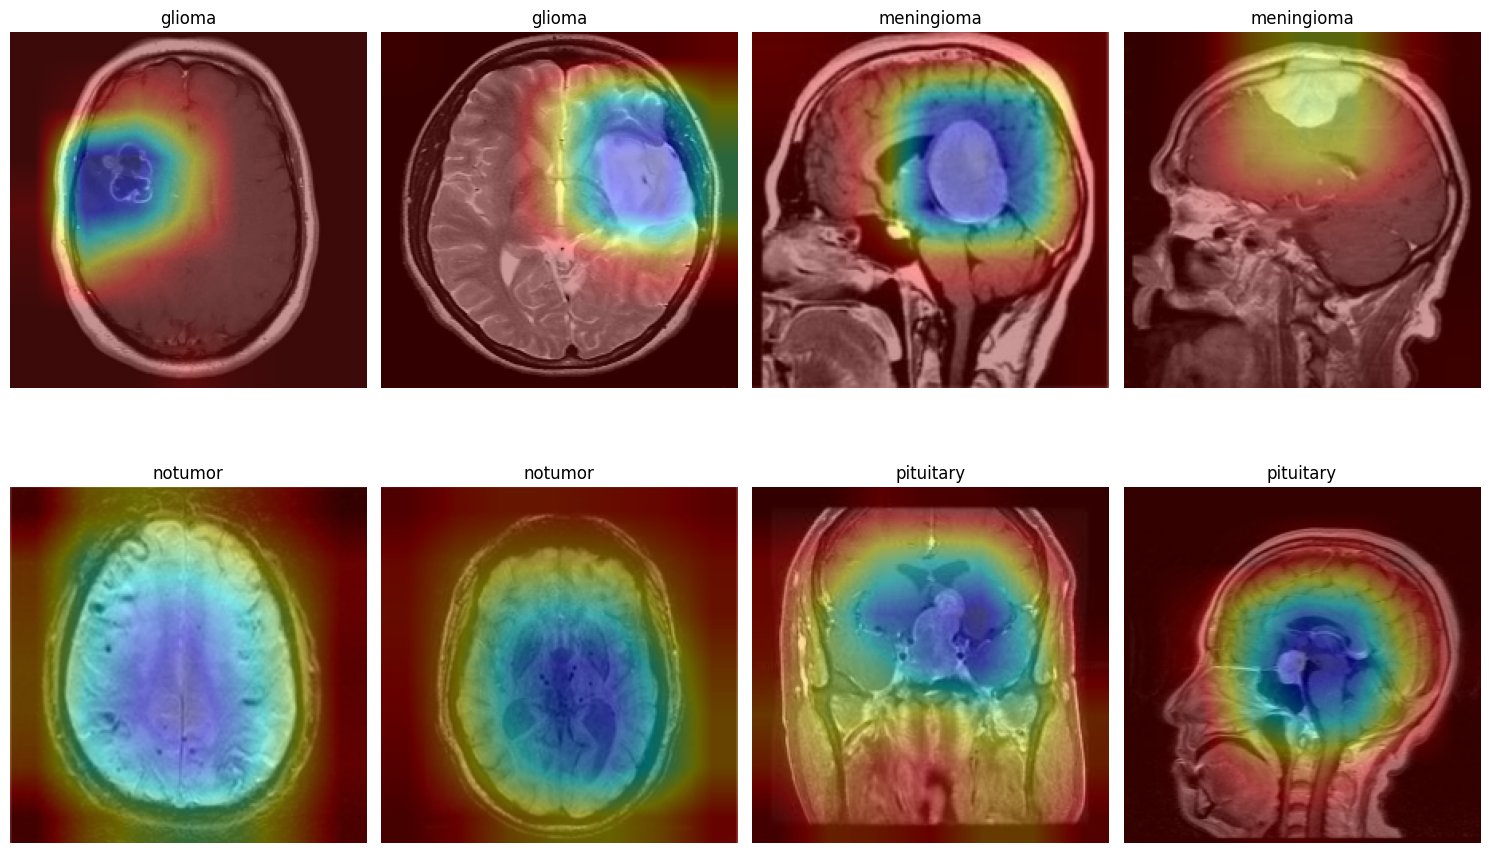

In [13]:
# ==============================
# 🔥 Part 5 — Grad-CAM for Multiple Test Images
# ==============================

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Load the trained model
model = tf.keras.models.load_model(save_path, compile=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

def preprocess_image(img_path):
    """Read and preprocess a single image for the model."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return np.expand_dims(img, axis=0), img  # return both model input and display image

def grad_cam(img_array, layer_name='conv5_block16_concat'):
    """Generate Grad-CAM heatmap for one image array and conv layer."""
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

def overlay_heatmap(original_img, heatmap):
    """Overlay heatmap on top of the original image."""
    # Convert both to uint8 [0–255]
    if original_img.max() <= 1.0:
        original_img = (original_img * 255).astype(np.uint8)
    else:
        original_img = original_img.astype(np.uint8)

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)
    return overlay


def show_multiple_gradcams(test_dir, n_images=8, layer_name='conv5_block16_concat'):
    """Display Grad-CAM for multiple test images."""
    class_names = sorted(os.listdir(test_dir))
    image_paths = []

    # Collect sample images from each class
    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            imgs = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            image_paths.extend(imgs[:n_images // len(class_names)])  # sample few per class

    # Show results
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths[:n_images]):
        img_array, original_img = preprocess_image(img_path)
        heatmap = grad_cam(img_array, layer_name)
        overlay = overlay_heatmap(original_img, heatmap)

        plt.subplot(2, n_images // 2, i + 1)
        plt.imshow(overlay)
        plt.title(os.path.basename(os.path.dirname(img_path)))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 🔍 Run for multiple images
show_multiple_gradcams(test_dir, n_images=8)


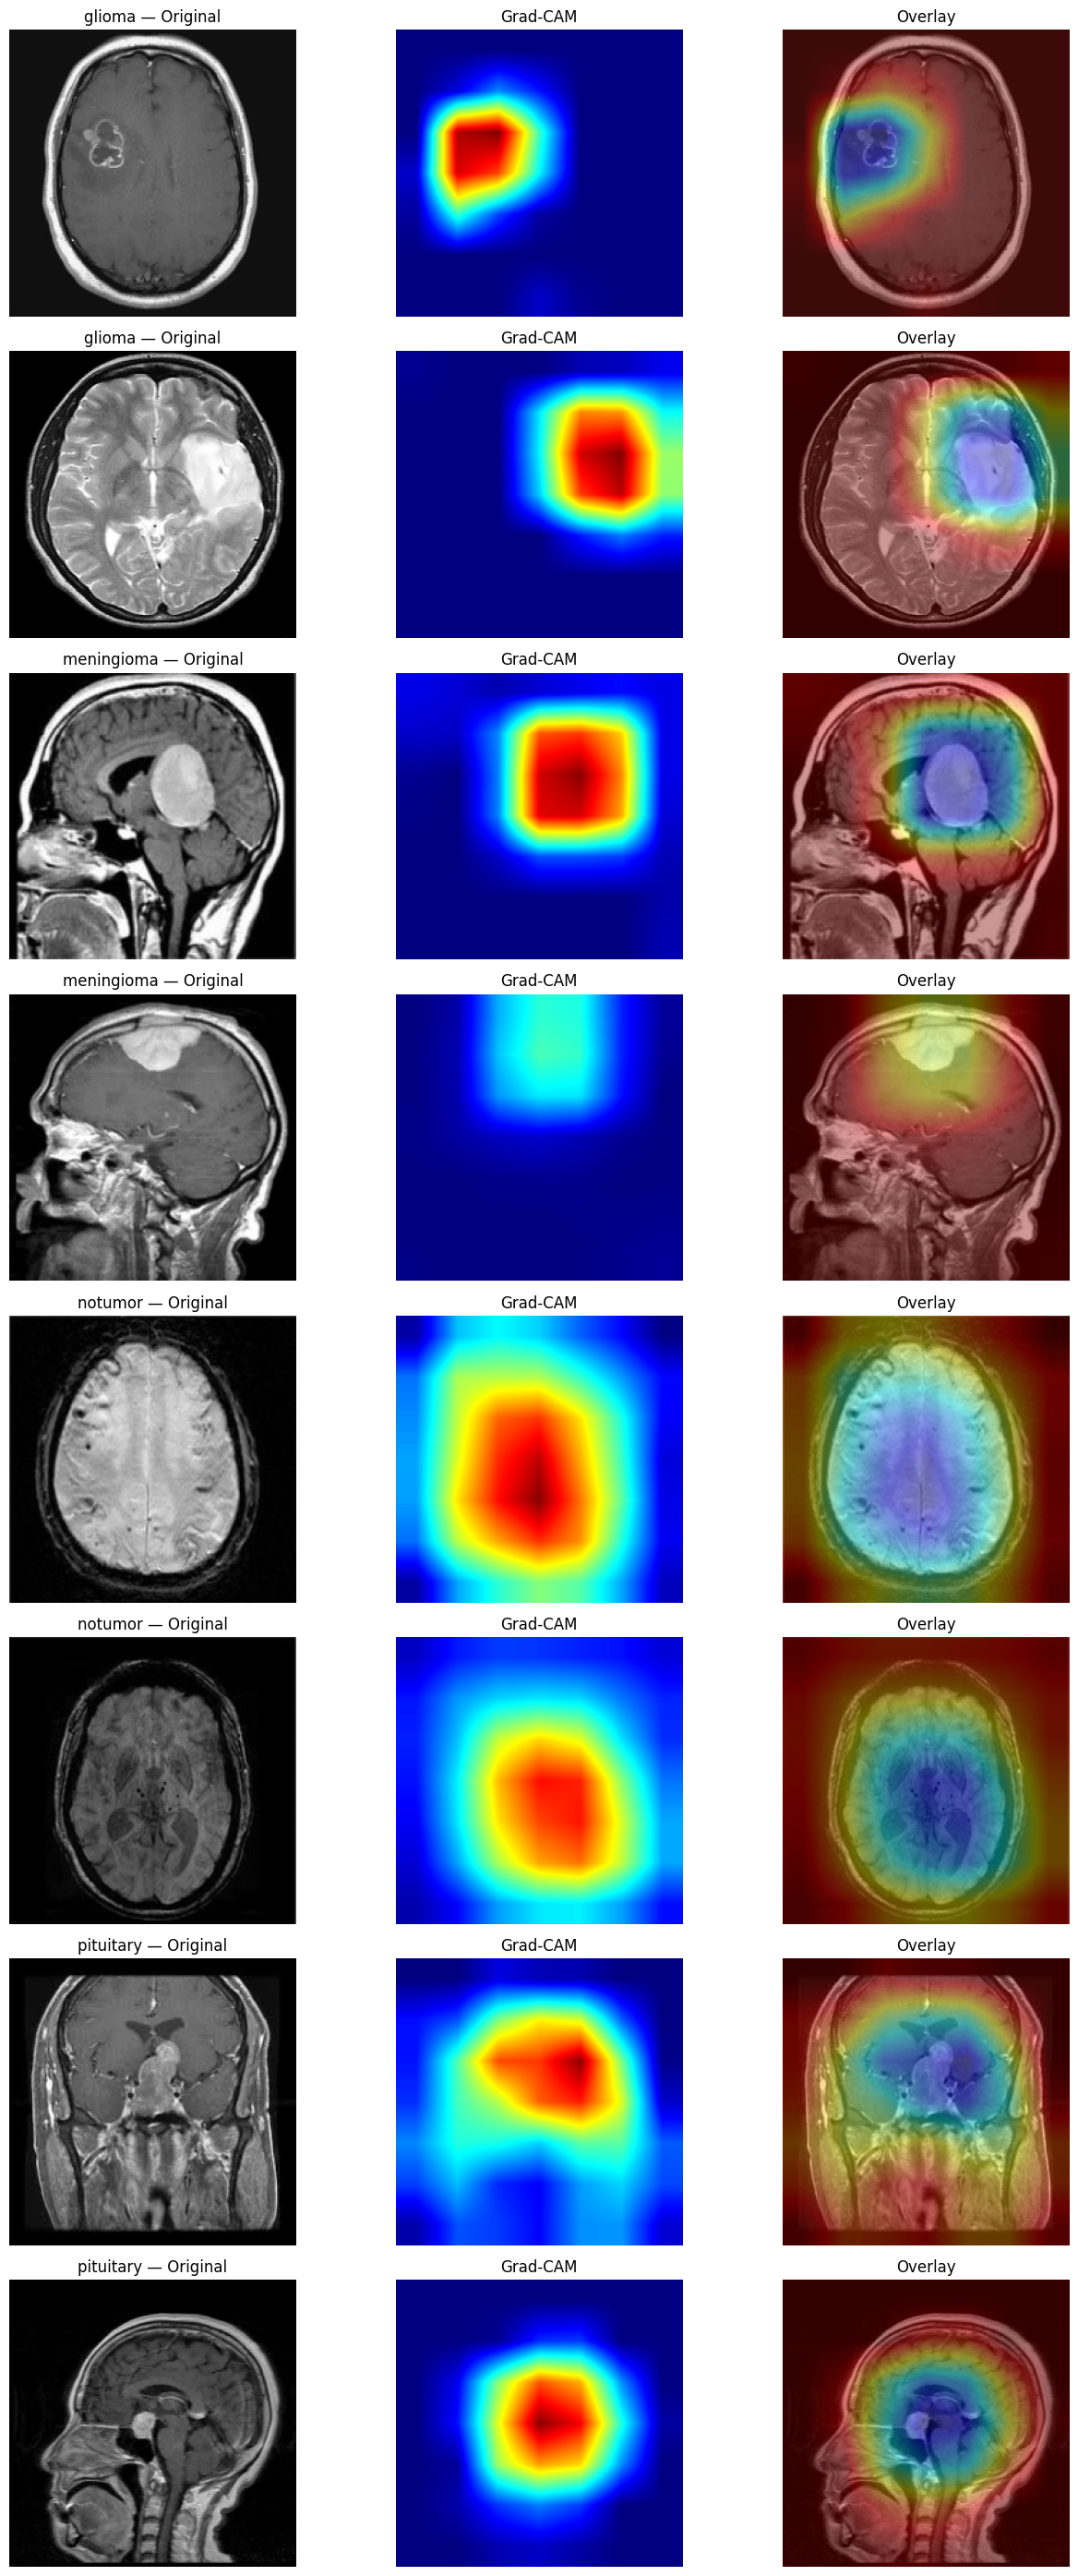

In [14]:
# ==============================
# 🔥 Part 5 — Grad-CAM (Multi-Image + Side-by-Side View)
# ==============================

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Load the trained model
model = tf.keras.models.load_model(save_path, compile=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

def preprocess_image(img_path):
    """Read and preprocess a single image for the model."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return np.expand_dims(img, axis=0), img  # model input, display image

def grad_cam(img_array, layer_name='conv5_block16_concat'):
    """Generate Grad-CAM heatmap for one image array."""
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

def overlay_heatmap(original_img, heatmap):
    """Overlay heatmap on top of the original image."""
    if original_img.max() <= 1.0:
        original_img = (original_img * 255).astype(np.uint8)
    else:
        original_img = original_img.astype(np.uint8)

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)
    return heatmap_color, overlay

def show_multiple_gradcams_side_by_side(test_dir, n_images=4, layer_name='conv5_block16_concat'):
    """Show each test image: Original | Grad-CAM | Overlay."""
    class_names = sorted(os.listdir(test_dir))
    image_paths = []

    # Collect sample images from each class
    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            imgs = [os.path.join(class_path, f) for f in os.listdir(class_path)
                    if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            image_paths.extend(imgs[:n_images // len(class_names)])

    cols = 3
    rows = len(image_paths)
    plt.figure(figsize=(cols * 4.5, rows * 3.5))

    for i, img_path in enumerate(image_paths):
        img_array, original_img = preprocess_image(img_path)
        heatmap = grad_cam(img_array, layer_name)
        heatmap_color, overlay = overlay_heatmap(original_img, heatmap)

        class_label = os.path.basename(os.path.dirname(img_path))

        # Column 1 — Original
        plt.subplot(rows, cols, i * cols + 1)
        plt.imshow(original_img)
        plt.title(f"{class_label} — Original")
        plt.axis("off")

        # Column 2 — Grad-CAM
        plt.subplot(rows, cols, i * cols + 2)
        plt.imshow(heatmap_color[..., ::-1])  # convert BGR to RGB
        plt.title("Grad-CAM")
        plt.axis("off")

        # Column 3 — Overlay
        plt.subplot(rows, cols, i * cols + 3)
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔍 Run it
show_multiple_gradcams_side_by_side(test_dir, n_images=8)


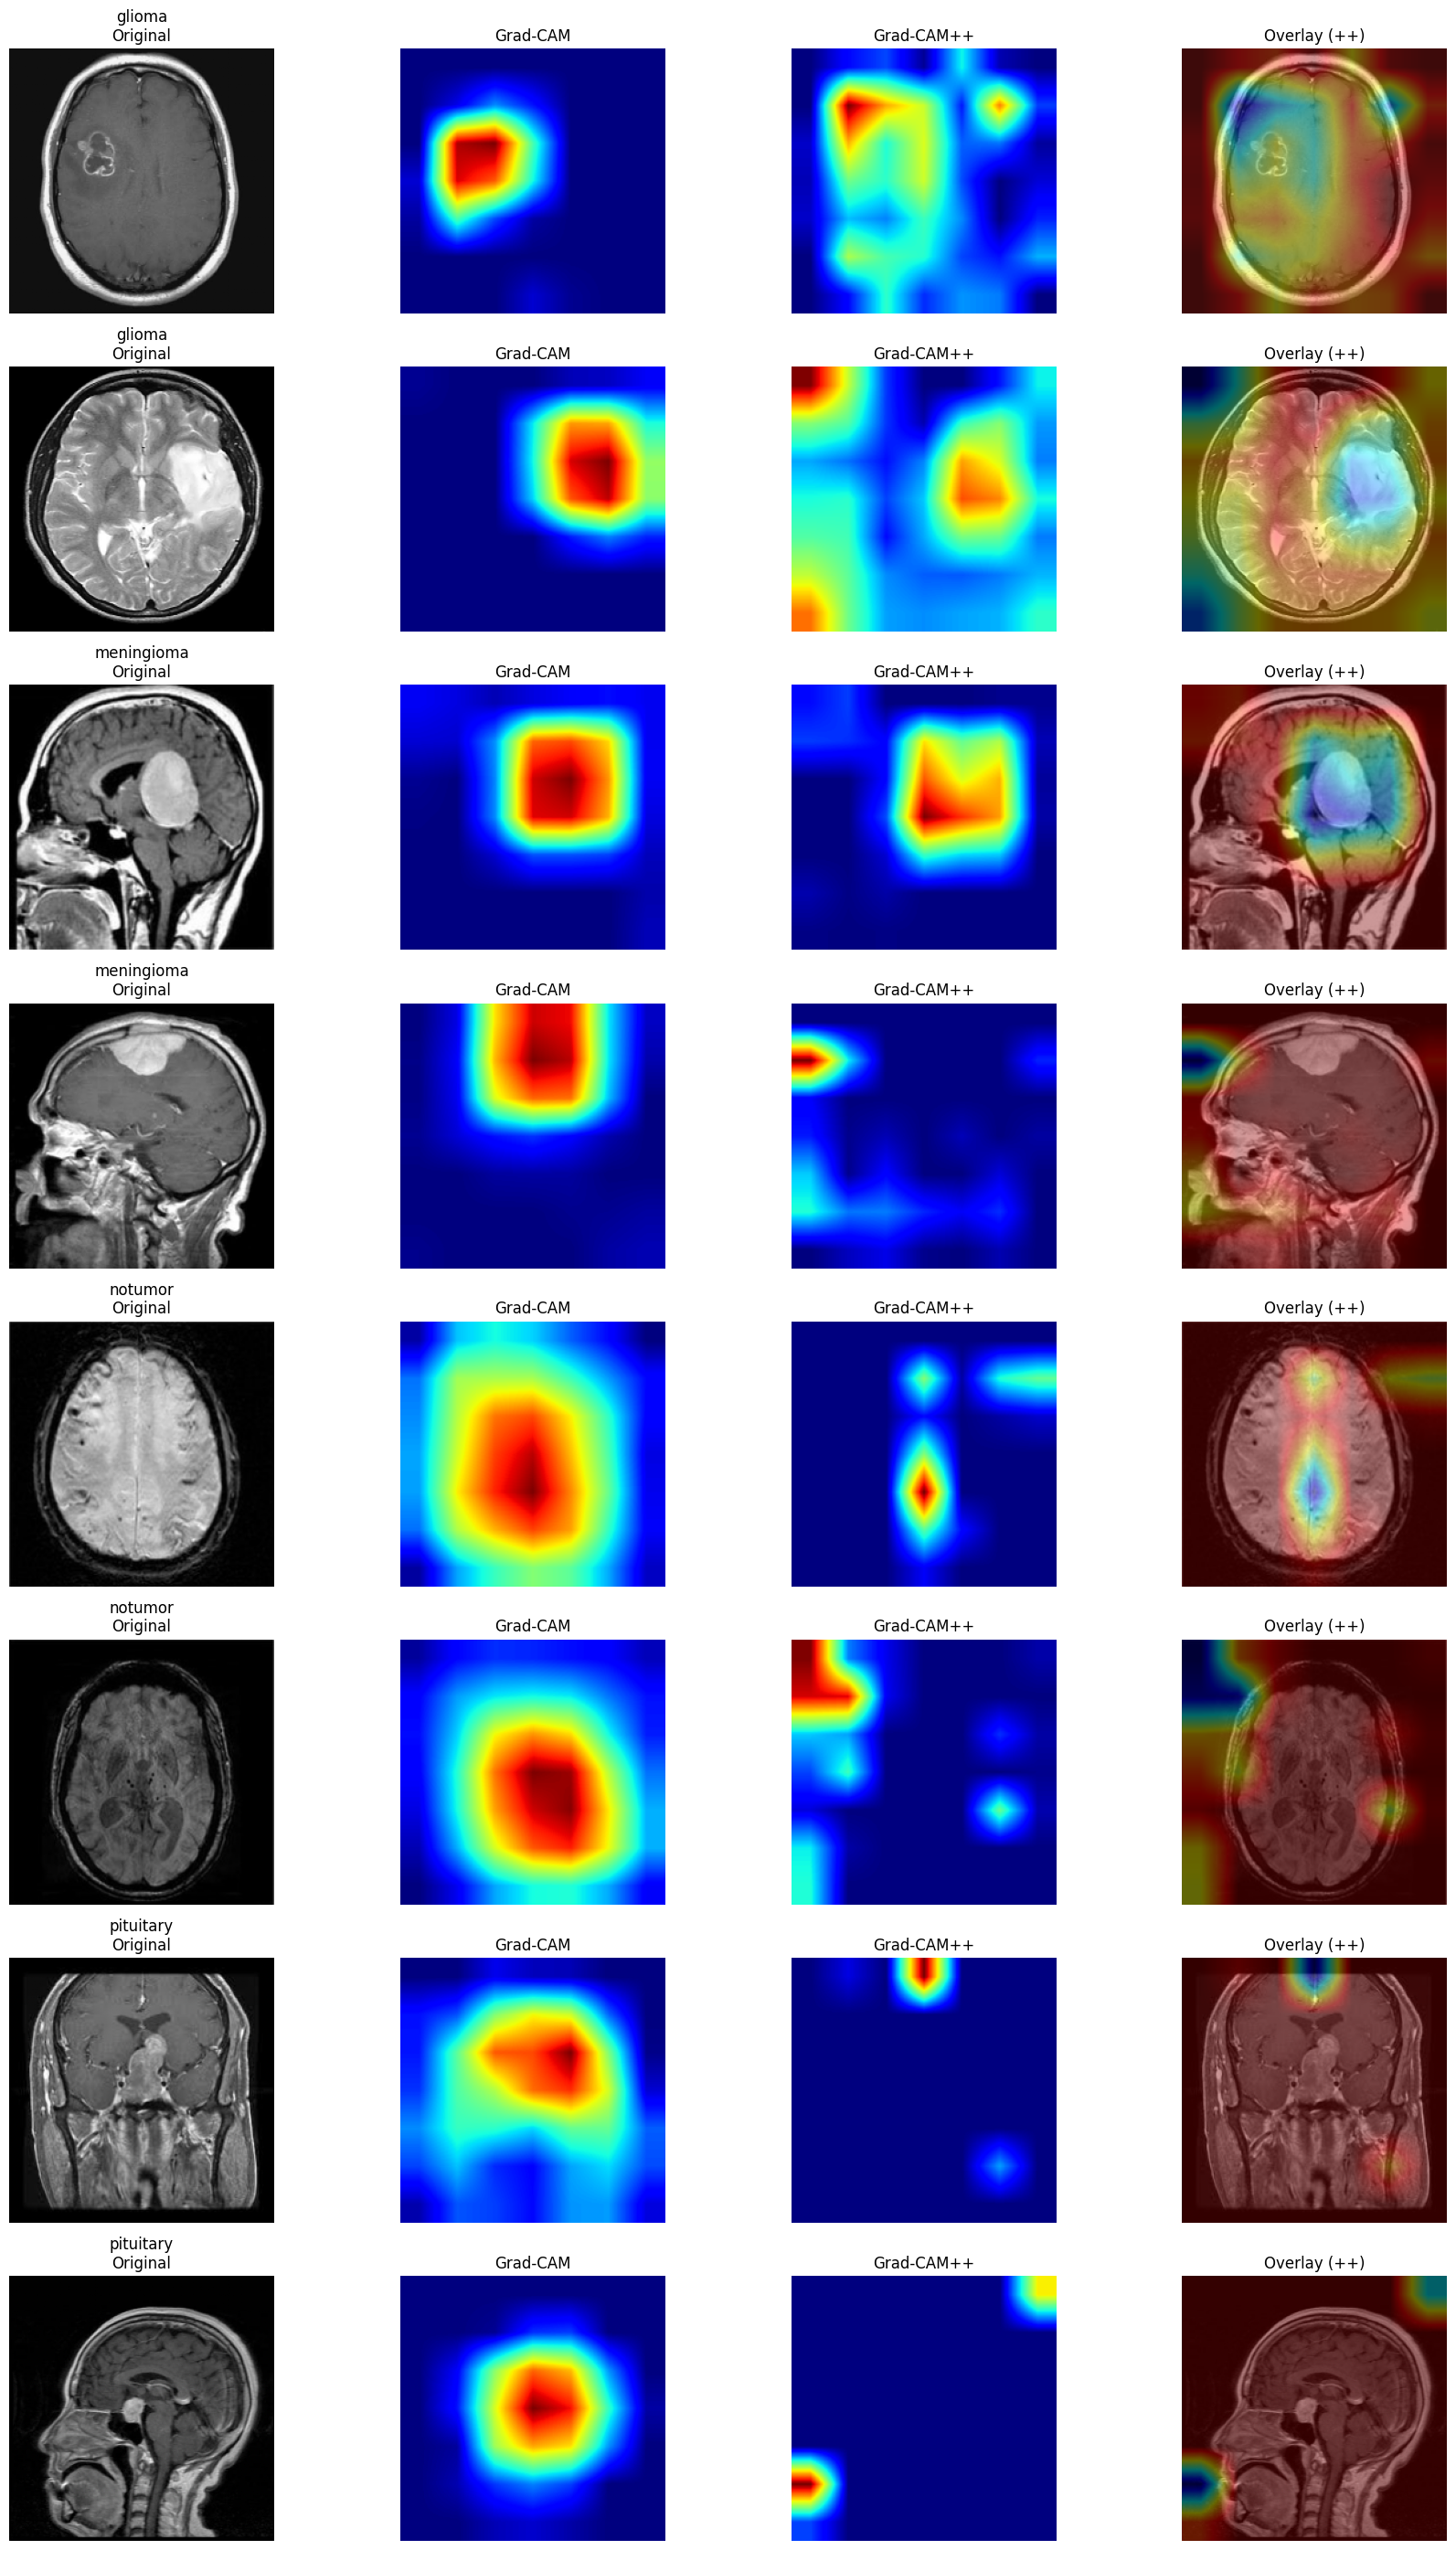

In [15]:
# ==============================
# 🔥 Part 5 — Grad-CAM + Grad-CAM++ (Multi-Image Side-by-Side)
# ==============================

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Load your trained model
model = tf.keras.models.load_model(save_path, compile=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# --------------------------
# Utility Functions
# --------------------------
def preprocess_image(img_path):
    """Load and preprocess an image for model input."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return np.expand_dims(img, axis=0), img  # (1,224,224,3), (224,224,3)


# --------------------------
# Grad-CAM Implementation
# --------------------------
def grad_cam(img_array, layer_name='conv5_block16_concat'):
    """Compute Grad-CAM heatmap."""
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    return cv2.resize(heatmap, (224, 224))


# --------------------------
# Grad-CAM++ Implementation
# --------------------------
def grad_cam_plus_plus(img_array, layer_name='conv5_block16_concat'):
    """Compute Grad-CAM++ heatmap."""
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outputs, predictions = grad_model(img_array)
                pred_index = tf.argmax(predictions[0])
                loss = predictions[:, pred_index]

            grads = tape3.gradient(loss, conv_outputs)
        grads2 = tape2.gradient(grads, conv_outputs)
    grads3 = tape1.gradient(grads2, conv_outputs)

    conv_outputs = conv_outputs[0]
    grads = grads[0]
    grads2 = grads2[0]
    grads3 = grads3[0]

    numerator = grads2
    denominator = 2 * grads2 + grads3 * conv_outputs
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))
    alpha = numerator / denominator
    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(0, 1))

    cam = tf.reduce_sum(weights * conv_outputs, axis=-1)
    heatmap = np.maximum(cam, 0)
    heatmap /= (tf.math.reduce_max(heatmap) + 1e-8)
    return cv2.resize(heatmap.numpy(), (224, 224))


# --------------------------
# Overlay Utility
# --------------------------
def overlay_heatmap(original_img, heatmap):
    """Blend heatmap with the original image."""
    if original_img.max() <= 1.0:
        original_img = (original_img * 255).astype(np.uint8)
    else:
        original_img = original_img.astype(np.uint8)

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)
    return heatmap_color, overlay


# --------------------------
# Display Function
# --------------------------
def show_gradcam_and_gradcampp(test_dir, n_images=4, layer_name='conv5_block16_concat'):
    """Display Original | Grad-CAM | Grad-CAM++ | Overlay for multiple images."""
    class_names = sorted(os.listdir(test_dir))
    image_paths = []

    # Collect sample images
    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            imgs = [os.path.join(class_path, f) for f in os.listdir(class_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            image_paths.extend(imgs[:n_images // len(class_names)])

    cols = 4
    rows = len(image_paths)
    plt.figure(figsize=(cols * 4.5, rows * 3.5))

    for i, img_path in enumerate(image_paths):
        img_array, original_img = preprocess_image(img_path)
        heatmap_cam = grad_cam(img_array, layer_name)
        heatmap_campp = grad_cam_plus_plus(img_array, layer_name)
        _, overlay_campp = overlay_heatmap(original_img, heatmap_campp)

        class_label = os.path.basename(os.path.dirname(img_path))

        # Original
        plt.subplot(rows, cols, i * cols + 1)
        plt.imshow(original_img)
        plt.title(f"{class_label}\nOriginal")
        plt.axis("off")

        # Grad-CAM
        plt.subplot(rows, cols, i * cols + 2)
        plt.imshow(heatmap_cam, cmap='jet')
        plt.title("Grad-CAM")
        plt.axis("off")

        # Grad-CAM++
        plt.subplot(rows, cols, i * cols + 3)
        plt.imshow(heatmap_campp, cmap='jet')
        plt.title("Grad-CAM++")
        plt.axis("off")

        # Overlay (Grad-CAM++)
        plt.subplot(rows, cols, i * cols + 4)
        plt.imshow(overlay_campp)
        plt.title("Overlay (++)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# 🔍 Run visualization
show_gradcam_and_gradcampp(test_dir, n_images=8)
